In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import keras 
import cv2

Using TensorFlow backend.


In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg

%matplotlib inline
np.set_printoptions(suppress = True)

In [6]:
categories = ['alt.atheism', 'talk.religion.misc','comp.graphics','sci.space']
remove = ('headers','footers','quotes')
newsgroup_train = fetch_20newsgroups(subset = 'train', categories = categories, remove = remove)
newsgroup_test = fetch_20newsgroups(subset = 'test', categories = categories, remove = remove)

In [9]:
newsgroup_train.filenames.shape, newsgroup_train.target.shape

((2034,), (2034,))

Let's look at some of the data. 

In [11]:
print('\n'.join(newsgroup_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [13]:
np.array(newsgroup_train.target_names)[newsgroup_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [14]:
newsgroup_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [15]:
num_topics, num_top_words = 6,8

 ## stop words, stemming and lemmatization

### stop words

In [16]:
from sklearn.feature_extraction import stop_words
sorted(list(stop_words.ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

## STEMMING AND LEMMATIZATION

In [17]:
import nltk

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/odemakinde/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [19]:
from nltk import stem

In [21]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [22]:
word_list = ['feet','foot', 'foots','footing']

In [23]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [24]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

In [25]:
[wnl.lemmatize(word) for word in ['fly', 'flies','flying']]

['fly', 'fly', 'flying']

In [26]:
[porter.stem(word) for word in ['fly', 'flies','flying']]

['fli', 'fli', 'fli']

In [27]:
[wnl.lemmatize(word) for word in ['organize', 'organizes','organizing']]

['organize', 'organizes', 'organizing']

In [28]:
[porter.stem(word) for word in ['organize', 'organizes','organizing']]

['organ', 'organ', 'organ']

In [29]:
[wnl.lemmatize(word) for word in ['universe', 'university']]

['universe', 'university']

In [30]:
[porter.stem(word) for word in ['universe', 'university']]

['univers', 'univers']

stemming and lemmatization are language dependent. Languages with more complex
morphologies may show bigger benefits.

## Spacy

spacy is a very modern and fast nlp library

In [37]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
lookups = Lookups()
lookups.add_table("lemma_rules", {"noun": [["s", ""]]})
lemmatizer = Lemmatizer(lookups)

In [39]:
[lemmatizer.lookup(word) for word in word_list]

['feet', 'foot', 'foots', 'footing']

In [40]:
word_list

['feet', 'foot', 'foots', 'footing']

Spacy doesnt offer stemmer (since lemmatization is considered better -- this is an example of being optionated!)
stop words vary from library

In [43]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [45]:
sorted(list(nlp.Defaults.stop_words))[:20]

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also']

## Data preprocessing

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [47]:
vectorizer = CountVectorizer(stop_words = 'english') 

In [49]:
vectors = vectorizer.fit_transform(newsgroup_train.data).todense()
vectors.shape

(2034, 26576)

In [51]:
print(len(newsgroup_train.data), vectors.shape)

2034 (2034, 26576)


In [52]:
vocab = np.array(vectorizer.get_feature_names())

In [53]:
vocab.shape

(26576,)

In [54]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

# Singular value Decomposition (SVD)

The SVD algorithm factorizes a matrix into one matrix with orthogonal columns and one with orthogonal rows (along the diagonal matrix),
which contains the relative importance of each factor.
its an exact decomposition. widely used for linear algebra and specifically in data science including:
semantic analysis
collaborative filterning/recommendation
calculate moore-penrose pseudoinverse
data compression
principal component analysis

In [55]:
%time U, s, vh = linalg.svd(vectors, full_matrices = False)

CPU times: user 1min 18s, sys: 2.01 s, total: 1min 20s
Wall time: 23.1 s


In [56]:
print(U.shape, s.shape, vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [58]:
#confirm that this is a decomposition of the input

reconstructed_vectors = U @ np.diag(s) @vh
np.linalg.norm(reconstructed_vectors - vectors)


4.083314144815755e-12

In [59]:
np.allclose(reconstructed_vectors, vectors)

True

In [61]:
val, vlu = U.T @U, np.eye(U.shape[0])

In [68]:
val[:10]

array([[ 1., -0., -0., ..., -0.,  0., -0.],
       [-0.,  1., -0., ..., -0.,  0.,  0.],
       [-0., -0.,  1., ...,  0.,  0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0.,  0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [67]:
np.eye(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [60]:
#confirm that U and V are orthnormal

np.allclose(U.T @U, np.eye(U.shape[0]))
np.allclose(vh @vh.T, np.eye(vh.shape[0]))

True

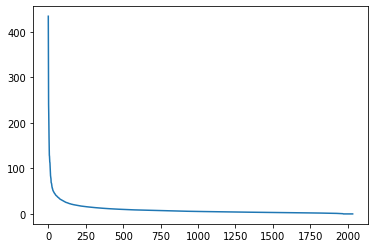

In [69]:
# what can we say about the singular values s?

plt.plot(s)


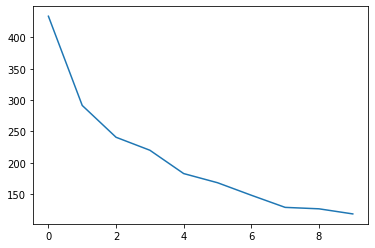

In [70]:
plt.plot(s[:10])

In [74]:
num_top_words = 8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [75]:
show_topics(vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

## Non-negative Matrix Factorization (NMF)

nmf from sklearn

In [76]:
m, n = vectors.shape
d = 5 #num topics

clf = decomposition.NMF(n_components = d, random_state = 1)
w1 = clf.fit_transform(vectors)
h1 = clf.components_

In [78]:
show_topics(h1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

# TF-IDF

topic frequency inverse document frequency

In [79]:
vectorizer_tfidf = TfidfVectorizer(stop_words = 'english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroup_train.data)

In [82]:
w1 = clf.fit_transform(vectors_tfidf)
h1 = clf.components_

In [83]:
show_topics(h1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

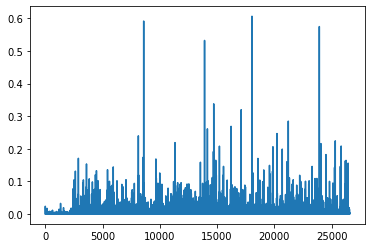

In [84]:
plt.plot(clf.components_[0])

In [85]:
clf.reconstruction_err_

43.712926057952785